#### Git configs

In [ ]:

username = 'ayodyak'
repo = 'Y2_S1_Batch02_Ku28'

In [ ]:
!git remote set-url origin https://github.com/{username}/{repo}

In [ ]:
!git clone https://github.com/{username}/{repo}

Cloning into 'Y2_S1_Batch02_Ku28'...
remote: Enumerating objects: 71518, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 71518 (delta 1), reused 11 (delta 1), pack-reused 71493 (from 1)
Receiving objects: 100% (71518/71518), 1.43 GiB | 31.62 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (71463/71463), done.


In [4]:
%cd {repo}

/content/Y2_S1_Batch02_Ku28


#### Pre Processing

In [ ]:
import os
from PIL import Image
import numpy as np
from PIL import Image, ImageEnhance
from collections import Counter
import random

In [ ]:

dataset_path = '/content/Y2_S1_Batch02_Ku28/data/technic 1'

# Get only directory names inside Dataset
class_names = [
    name for name in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, name))
]

print(class_names)



['Potato___Late_blight', 'Corn_(maize)___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Corn_(maize)___Northern_Leaf_Blight', 'Apple___Cedar_apple_rust', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato_healthy', 'Corn_(maize)___Common_rust_', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus', 'Apple___Apple_scab', 'Apple___healthy', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Apple___Black_rot', 'Potato___healthy', 'Tomato_Late_blight']


In [7]:


src_root = '/content/Y2_S1_Batch02_Ku28/data/technic 1'
dst_root = '/content/Y2_S1_Batch02_Ku28/data/technic_scale'

# create destination root if not exists
os.makedirs(dst_root, exist_ok=True)

def normalize_image(img: Image.Image) -> Image.Image:
    """Scale pixel values to [0,1] then back to 0–255 as uint8 for saving."""
    arr = np.asarray(img).astype('float32') / 255.0    # scale to [0,1]
    arr = (arr * 255).astype('uint8')                  # back to uint8 for file
    return Image.fromarray(arr)

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # make matching class folder in destination
    dst_class_path = os.path.join(dst_root, class_name)
    os.makedirs(dst_class_path, exist_ok=True)

    for file in os.listdir(class_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src_file = os.path.join(class_path, file)
            dst_file = os.path.join(dst_class_path, file)

            img = Image.open(src_file).convert('RGB')
            img_norm = normalize_image(img)
            img_norm.save(dst_file)


In [9]:
!pip install scikit-image opencv-python matplotlib tqdm


In [ ]:

import os, glob, random
from tqdm import tqdm
import cv2
import numpy as np
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

data_dir = "/content/Y2_S1_Batch02_Ku28/data/technic_scale"  
output_dir = "/content/Y2_S1_Batch02_Ku28/data/technic2"
os.makedirs(output_dir, exist_ok=True)

def single_scale_retinex(channel, sigma=80):
    # channel: float32 (already >0)
    blur = cv2.GaussianBlur(channel, (0,0), sigma)
    return np.log(channel + 1.0) - np.log(blur + 1.0)

def retinex_correct(img_rgb, sigma=80):
    """
    Input: RGB uint8 image (H,W,3)
    Output: uint8 RGB image (H,W,3)
    """
    # handle weird channel counts
    if img_rgb is None:
        return None
    if img_rgb.ndim == 2:
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    if img_rgb.shape[2] == 4:
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGRA2BGR)

    img = img_rgb.astype(np.float32) + 1e-6  # small eps to avoid log(0)
    out = np.zeros_like(img, dtype=np.float32)

    for c in range(3):
        ret = single_scale_retinex(img[:, :, c], sigma=sigma)
        # Normalize per-channel to [0,1] --> safe for img_as_ubyte
        mn, mx = ret.min(), ret.max()
        if mx - mn < 1e-8:
            norm = np.zeros_like(ret)
        else:
            norm = (ret - mn) / (mx - mn)
        out[:, :, c] = norm

    # skimage.img_as_ubyte expects floats in [0,1] -> returns uint8 0-255
    return img_as_ubyte(out)

# Batch process with safety checks
for cls in sorted(os.listdir(data_dir)):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    out_cls = os.path.join(output_dir, cls)
    os.makedirs(out_cls, exist_ok=True)

    files = [f for f in os.listdir(cls_path)
             if f.lower().endswith(('.jpg','.jpeg','.png'))]
    for f in tqdm(files, desc=cls, ncols=80):
        src = os.path.join(cls_path, f)
        img_bgr = cv2.imread(src)  # BGR or None
        if img_bgr is None:
            print("WARN: failed to read", src)
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        corrected = retinex_correct(img_rgb, sigma=80)
        if corrected is None:
            continue
        # save as PNG or same ext (PNG avoids compression artifacts)
        save_path = os.path.join(out_cls, f)
        # convert back to BGR for cv2.imwrite
        cv2.imwrite(save_path, cv2.cvtColor(corrected, cv2.COLOR_RGB2BGR))


Apple___healthy: 100%|██████████████████████| 2008/2008 [01:46<00:00, 18.90it/s]
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 100%|█| 1642/1642 [01:26<00:
Tomato_Septoria_leaf_spot: 100%|████████████| 1771/1771 [01:33<00:00, 18.98it/s]
Tomato_Spider_mites_Two_spotted_spider_mite: 100%|█| 1676/1676 [01:28<00:00, 18.
Tomato__Target_Spot: 100%|██████████████████| 1404/1404 [01:14<00:00, 18.86it/s]
Tomato__Tomato_YellowLeaf__Curl_Virus: 100%|█| 3208/3208 [02:48<00:00, 19.03it/s
Tomato_healthy: 100%|███████████████████████| 1591/1591 [01:24<00:00, 18.90it/s]


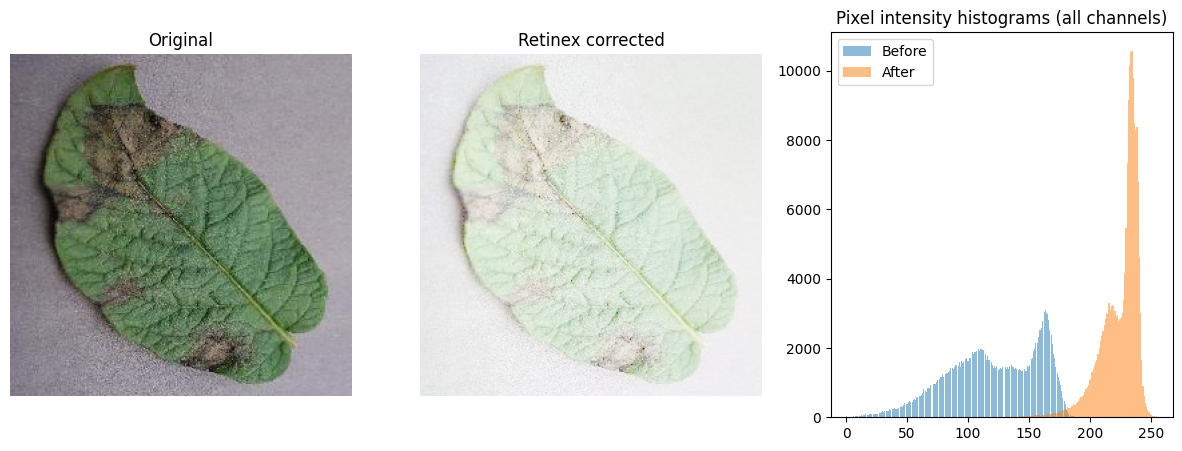

Mean brightness (V channel) - before: 131.4, after: 230.0



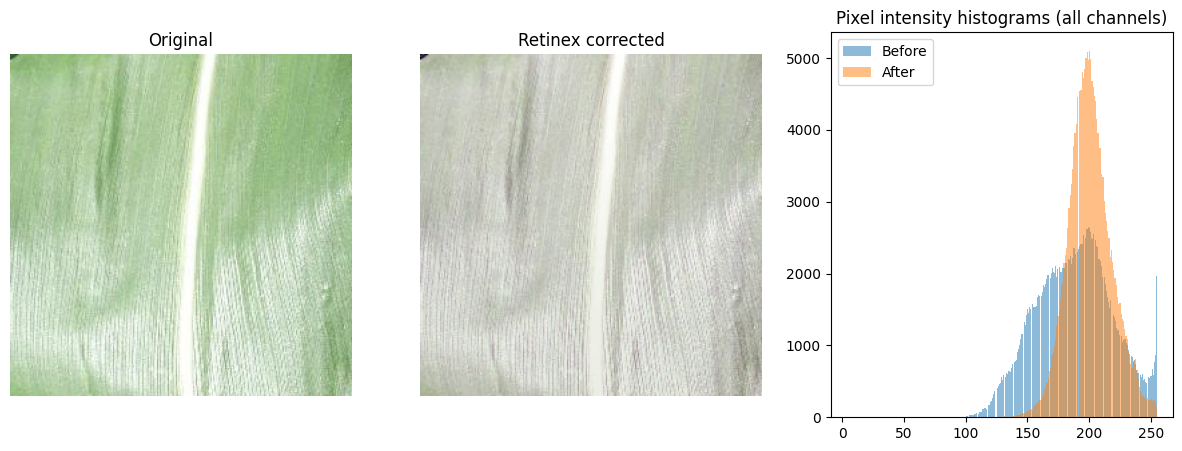

Mean brightness (V channel) - before: 208.7, after: 205.2



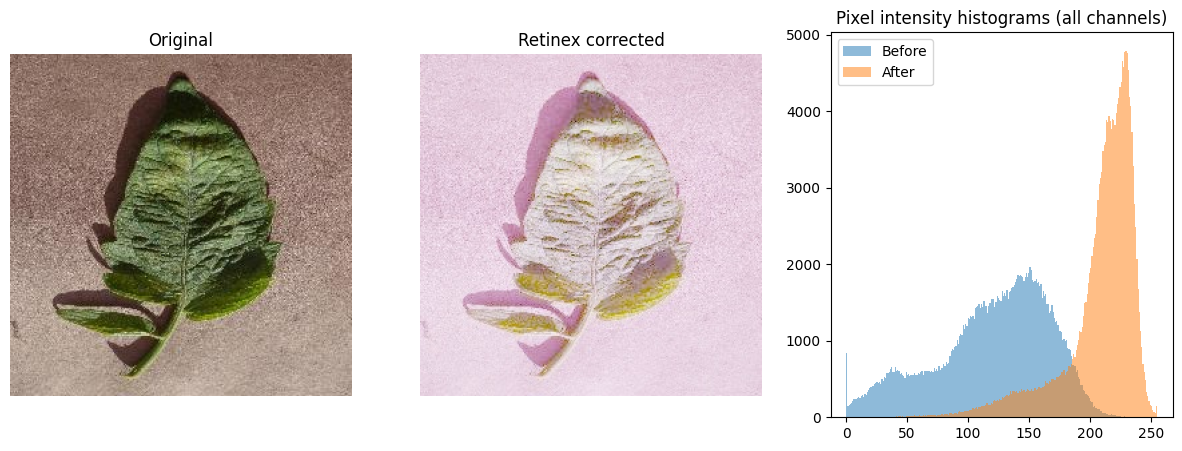

Mean brightness (V channel) - before: 138.8, after: 220.9



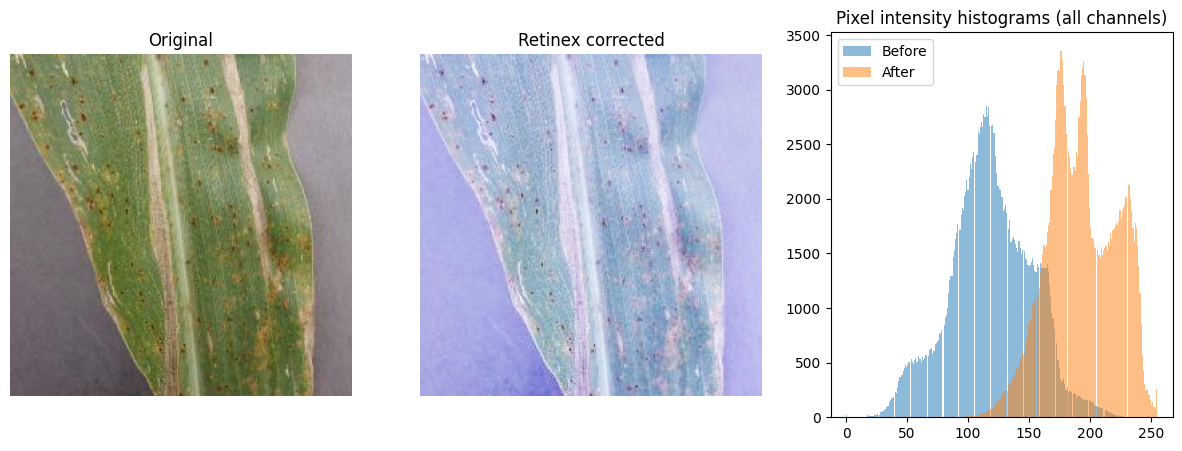

Mean brightness (V channel) - before: 133.6, after: 219.8



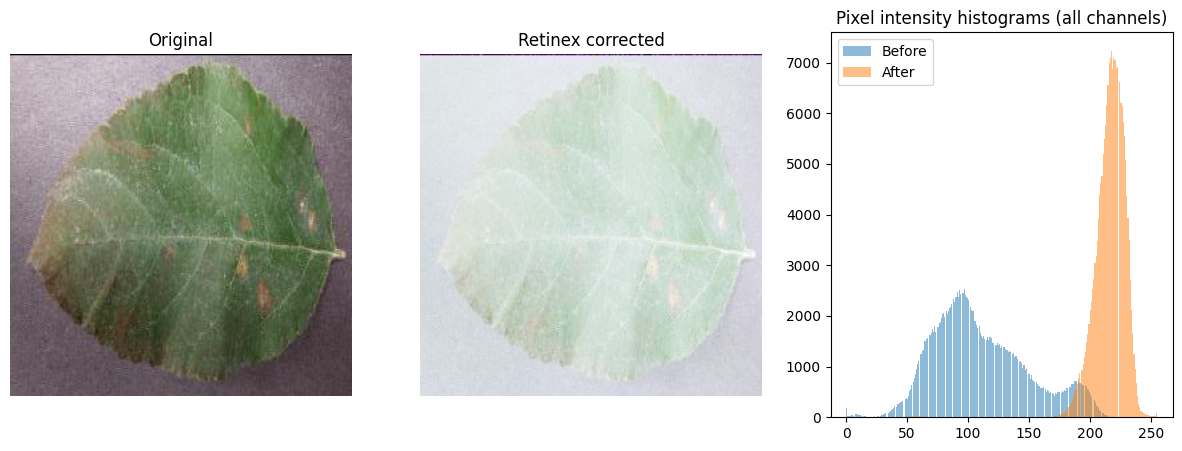

Mean brightness (V channel) - before: 122.8, after: 223.1



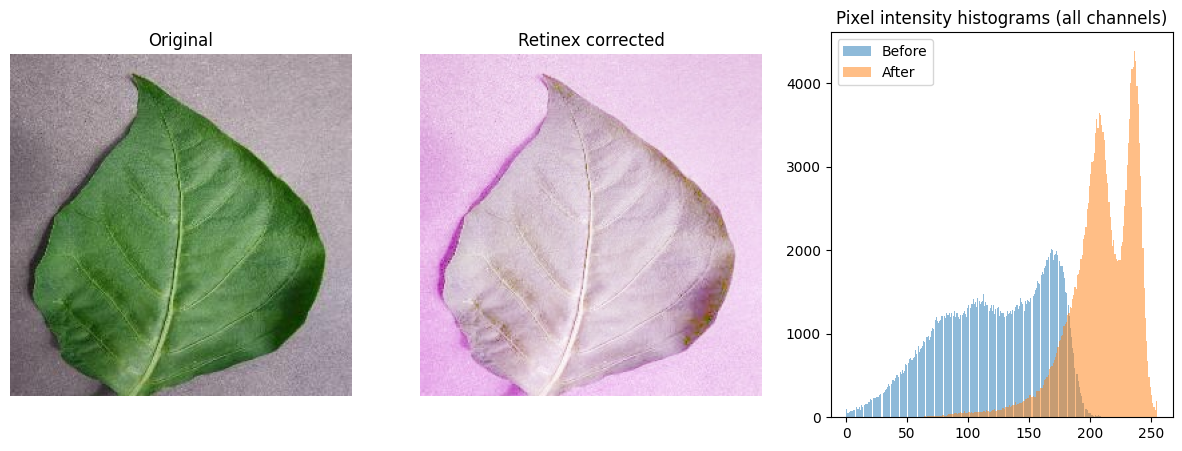

Mean brightness (V channel) - before: 140.4, after: 221.8



In [11]:
def mean_brightness_rgb(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    return float(hsv[:, :, 2].mean())

# pick some random sample images from original folder
sample_paths = []
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path): continue
    imgs = glob.glob(os.path.join(cls_path, '*'))
    jpgs = [p for p in imgs if p.lower().endswith(('.jpg','.jpeg','.png'))]
    if jpgs:
        sample_paths.append(random.choice(jpgs))

for src in sample_paths[:6]:
    rel = os.path.relpath(src, data_dir)
    dst = os.path.join(output_dir, rel)
    if not os.path.exists(dst):
        # skip if not processed yet
        continue

    before = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
    after  = cv2.cvtColor(cv2.imread(dst), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].imshow(before); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(after);  ax[1].set_title('Retinex corrected'); ax[1].axis('off')

    # Histograms (combined RGB)
    ax[2].hist(before.ravel(), bins=256, alpha=0.5, label='Before')
    ax[2].hist(after.ravel(),  bins=256, alpha=0.5, label='After')
    ax[2].set_title('Pixel intensity histograms (all channels)')
    ax[2].legend()
    plt.show()

    print("Mean brightness (V channel) - before: {:.1f}, after: {:.1f}\n"
          .format(mean_brightness_rgb(before), mean_brightness_rgb(after)))
